# Low-Rank Adaptation with Large Language Models
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1exGP_iTq__FLFwK9bm7HnFI-foIdoiLo?usp=sharing)

**Pycon Prague 2023, Adam Zíka**


This notebook illustrates an application of Low Rank Adaptation (LoRA) with Llama2.  The notebook is inspired from Inspired from https://colab.research.google.com/drive/1PEQyJO1-f6j0S_XJ8DV50NkpzasXkrzd?usp=sharing

Additional reading materials
- Hu, Edward J., et al. "Lora: Low-rank adaptation of large language models." (2021).
- Dettmers, Tim, et al. "Qlora: Efficient finetuning of quantized llms." (2023).
- https://www.philschmid.de/instruction-tune-llama-2
- https://towardsdatascience.com/fine-tune-your-own-llama-2-model-in-a-colab-notebook-df9823a04a32
- https://huggingface.co/blog/stackllama

Switch to T4 GPU compute engine (or better GPU) to run in Google Colab.

The code filters (`dataset.select(...)`) out majority data - remove the filters to run it in the full scale. The results used in the presentation were obtained without filtering.

In [ ]:
!pip3 install evaluate nltk rouge_score transformers python-dotenv bitsandbytes peft accelerate

In [2]:
import os

import pandas as pd
from datasets import load_dataset
import evaluate
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    DataCollatorForLanguageModeling,
    Trainer,
)
from peft import (
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftModel,
)
from huggingface_hub import login, notebook_login
from dotenv import load_dotenv
from tqdm import tqdm
from torch.utils.data import DataLoader
import gc
import scipy

In [3]:
# login to HuggingFace to download Llama2
load_dotenv()
if os.getenv("HF_HUB_TOKEN") is not None:
    # create `.env` file not to fill the token manually. The .env should include:
    # HF_HUB_TOKEN="YOUR TOKEN"
    login(os.getenv("HF_HUB_TOKEN"))
else:
    notebook_login()

# Parameters

In [4]:
max_model_input_len = 1024  # max model output length
model_id = "meta-llama/Llama-2-7b-chat-hf"

# Data

In [5]:
# load the dataset
dsum_text = load_dataset("knkarthick/dialogsum")
# you can use `load_dataset("samsum")` and fine-tune on a different dataset
# it is a good excercise to do to try changing the LoRA adapters on the fly


def print_dialogue(dialogue, pred_summary=None):
    print("==Dialogue==")
    print(dialogue["dialogue"])
    print("\n==Summary==")
    print(dialogue["summary"])
    if pred_summary is not None:
        print("\n==Predicted summary==")
        print(pred_summary)


print_dialogue(dsum_text["validation"][0])

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

==Dialogue==
#Person1#: Hello, how are you doing today?
#Person2#: I ' Ve been having trouble breathing lately.
#Person1#: Have you had any type of cold lately?
#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.
#Person1#: Do you have any allergies that you know of?
#Person2#: No, I don ' t have any allergies that I know of.
#Person1#: Does this happen all the time or mostly when you are active?
#Person2#: It happens a lot when I work out.
#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.
#Person2#: Thank you for your help, doctor.

==Summary==
#Person2# has trouble breathing. The doctor asks #Person2# about it and will send #Person2# to a pulmonary specialist.


In [6]:
# `default_sys` is a default system message of Llama2. A system message is
# text that is prepended to the prompt. It’s used in a chat context to help
# guide or constrain model behavior. [https://replicate.com/blog/how-to-prompt-llama]

default_sys = """You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.
Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content.
Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct.
If you don't know the answer to a question, please don't share false information.
"""


def format_prompt(sys, dialogue, answer=""):
    eos = "</s>" if answer != "" else ""
    # the prompt does not include the BOS token `<s>` because the tokenizer adds it automatically
    # the prompt below is created such that it reflects the instructions that were provided to the
    # labellers of DialogSum dataset. see https://github.com/cylnlp/dialogsum
    return f"""[INST] <<SYS>>
{sys}
<</SYS>>

Your task is to generate a summary of a conversation. The summary needs to
- Convey the most salient information
- Be brief
- Preserve important named entities within the conversation
- Be written from an observer perspective
- Be written in formal language

The conversation is:
{dialogue}

Summarize the conversation now.[/INST] {answer} {eos}"""


print(format_prompt(default_sys, dsum_text["validation"][0]["dialogue"]))

[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.
Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. 
Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct.
If you don't know the answer to a question, please don't share false information.

<</SYS>>

Your task is to generate a summary of a conversation. The summary needs to 
- Convey the most salient information
- Be brief
- Preserve important named entities within the conversation
- Be written from an observer perspective
- Be written in formal language

The conversation is:
#Person1#: Hello, how are you doing today?
#Person2#: I ' Ve been having trouble breathing lately.
#Person1#: Have you had any type of cold lately?
#Person2#: No, I haven ' t had a col

In [7]:
def load_tokenizer(model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    # pad token needs to be added explictly to the tokenizer when training the model
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    tokenizer.padding_side = "right"
    return tokenizer


tokenizer = load_tokenizer(model_id)

In [8]:
def process_dataset(df):
    df = df.map(
        lambda example: {
            "prompts": format_prompt(
                default_sys, example["dialogue"], example["summary"]
            )
        }
    )
    df = df.map(
        lambda batch: tokenizer(
            batch["prompts"], max_length=max_model_input_len, truncation=True
        ),
        batched=True,
        remove_columns=df["train"].features.keys(),
    )
    return df.filter(lambda sample: len(sample["input_ids"]) < max_model_input_len)


dsum = process_dataset(dsum_text)

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12460 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [9]:
# `max_tokens_in_summary` is used as a parameter for generating the summaries
max_tokens_in_summary = int(
    pd.Series(
        dsum_text["train"].map(
            lambda batch: tokenizer(
                batch["summary"], max_length=max_model_input_len, truncation=True
            ),
            batched=True,
        )["input_ids"]
    )
    .apply(len)
    .max()
    * 1.1  # 10% extra slack
)
f"Max new tokens in summary is: {max_tokens_in_summary}"

Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

'Max new tokens in summary is: 289'

# Full fine-tuning
Training all model parameters. The model is quantized during the training according to QLoRA (https://arxiv.org/abs/2305.14314) to save GPU memory.

In [10]:
def load_model(model_id, n_tokens, quantize=True):
    # quantization config used with QLoRA (https://arxiv.org/abs/2305.14314)
    bnb_config = None
    if quantize:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            # free Google Colab does not support float16
            bnb_4bit_compute_dtype=torch.float32,
        )

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        use_cache=False,
        torch_dtype=torch.float32,  # comment out if running outside of Google Colab
        quantization_config=bnb_config,
    )
    model.resize_token_embeddings(n_tokens)

    return model

In [11]:
model = load_model(model_id, len(tokenizer))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [12]:
def train_model(model, train_dataset, eval_dataset, output_dir):
    model.train()

    trainer = Trainer(
        model,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        # training with next token prediction
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
        # feel free to adjust the hyperparameters below
        args=TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=5,
            # set the batch size according to the size of yor GPU memory
            per_device_train_batch_size=1,
            per_device_eval_batch_size=1,
            gradient_accumulation_steps=8,
            gradient_checkpointing=True,
            optim="paged_adamw_32bit",
            save_steps=0,
            logging_steps=5,
            learning_rate=2e-4,
            weight_decay=0.001,
            max_grad_norm=0.3,
            warmup_ratio=0.03,
            lr_scheduler_type="cosine",
            evaluation_strategy="epoch",
            save_strategy="no",
            seed=42,
        ),
    )

    train_output = trainer.train()

    trainer.log_metrics("train", train_output.metrics)
    trainer.save_metrics("train", train_output.metrics)
    trainer.save_state()
    return trainer

In [13]:
train_model(
    model,
    train_dataset=dsum["train"].select(range(10)),
    eval_dataset=dsum["validation"].select(range(5)),
    output_dir="full-finetuning",
)

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
0,No log,2.328373
1,No log,1.870373
2,No log,1.605678
4,1.885400,1.453020


***** train metrics *****
  epoch                    =        4.0
  total_flos               =   333852GF
  train_loss               =     1.8854
  train_runtime            = 0:05:26.97
  train_samples_per_second =      0.153
  train_steps_per_second   =      0.015


In [14]:
def extract_prediction(pred_text, inst_end="[/INST]"):
    inst_end_pos = pred_text.rfind(inst_end)
    return pred_text[inst_end_pos + len(inst_end) :].strip()


def predict_summary(prompt, tokenizer, model, max_tokens_in_summary):
    """Predicts a summary with some default generation config."""
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens_in_summary,
        eos_token_id=tokenizer.eos_token_id,
        do_sample=True,
        top_p=0.95,
        temperature=0.95,
    )
    final_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    return extract_prediction(final_outputs)

In [15]:
# prediction with a sample dialogue
pred_summary = predict_summary(
    format_prompt(default_sys, dsum_text["validation"][0]["dialogue"]),
    tokenizer,
    model,
    max_tokens_in_summary,
)
pred_summary

'Sure, here\'s a summary of the conversation you provided:\nPerson 1 greeted Person 2 with a friendly "hello," asking how they were doing. Person 2 disclosed that they had been experiencing difficulty breathing and mentioned that they had not had a cold. In response, Person 1 asked if they had any allergies, to which Person 2 replied in the negative. Person 1 then asked if the shortness of breath occurred frequently or mostly during physical activity. Person 2 confirmed that it happened often when they exercised. Finally, Person 1 suggested that they see a pulmonary specialist for further evaluation.'

In [16]:
def eval_model(dataset, model, max_tokens_in_summary, sys_msg):
    """Extracts the predictions and calculates the Rouge scores."""
    refs = []
    preds = []
    model.eval()
    with torch.no_grad():
        for dialogue, summary in tqdm(zip(dataset["dialogue"], dataset["summary"])):
            pred_summary = predict_summary(
                format_prompt(sys_msg, dialogue),
                tokenizer,
                model,
                max_tokens_in_summary,
            )
            preds.append(pred_summary)
            refs.append(summary)

    rouge = evaluate.load("rouge")
    return rouge.compute(predictions=preds, references=refs), refs, preds

In [17]:
rouge, refs, preds = eval_model(
    # remove the `select(..)` to evaluate on the full dataset
    dsum_text["test"].select(range(10)),
    model,
    max_tokens_in_summary,
    default_sys,
)
rouge

10it [03:57, 23.70s/it]


{'rouge1': 0.15902960889605994,
 'rouge2': 0.05346670925014711,
 'rougeL': 0.11504202575307879,
 'rougeLsum': 0.12406533031518151}

# Fine-tuning with LoRA

In [18]:
# Empty GPU RAM. If ou run out of GPU memory in this section, try restarting the
# kernel, load the data and all declared functions, and run the notebook from here.

del model
torch.cuda.empty_cache()
gc.collect()

51

In [19]:
model_lora = load_model(model_id, len(tokenizer))

# `prepare_model_for_kbit_training(..)` i.a. freezes the existing model weights,
# enables gradient checkpointing, makes the input embedding layer trainable
# see more at https://github.com/huggingface/peft/blob/main/src/peft/utils/other.py#L92
model_lora = prepare_model_for_kbit_training(
    model_lora, use_gradient_checkpointing=True
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [20]:
peft_config = LoraConfig(
    r=32,
    # feel free to experiment to adapt all linear layers:
    # ['q_proj','k_proj','v_proj','o_proj','gate_proj','down_proj','up_proj','lm_head']
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
    # the paramters below do not affect performace much
    # see https://www.databricks.com/blog/efficient-fine-tuning-lora-guide-llms
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
)

model_lora = get_peft_model(model_lora, peft_config)
model_lora.print_trainable_parameters()

trainable params: 16,777,216 || all params: 6,755,201,024 || trainable%: 0.2483599813002397


In [21]:
train_model(
    model_lora,
    train_dataset=dsum["train"].select(range(10)),
    eval_dataset=dsum["validation"].select(range(5)),
    output_dir="full-finetuning",
)

model_lora.save_pretrained("dsum_lora_adapter")

Epoch,Training Loss,Validation Loss
0,No log,2.328377
1,No log,2.250182
2,No log,2.172271
4,2.347700,2.106030


***** train metrics *****
  epoch                    =        4.0
  total_flos               =   335514GF
  train_loss               =     2.3477
  train_runtime            = 0:05:27.87
  train_samples_per_second =      0.152
  train_steps_per_second   =      0.015


## Evaluation & inference

In [ ]:
# Empty GPU RAM. If ou run out of GPU memory in this section, try restarting the
# kernel, load the data and all declared functions, and run the notebook from here.

del model_lora
torch.cuda.empty_cache()
gc.collect()

71

In [ ]:
model = load_model(model_id, len(tokenizer))
model_lora = PeftModel.from_pretrained(model, "dsum_lora_adapter")
# if you trained another LoRA adapter (e.g. on samsum dataset), you can
# try to exchange it on the fly by calling `PeftModel.from_pretrained(model, "ADAPTER_NAME")`

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [ ]:
rouge, refs, preds = eval_model(
    # remove `select(..)` to evaluate on the full test dataset
    dsum_text["test"].select(range(10)),
    model_lora,
    max_tokens_in_summary,
    default_sys
)
rouge

10it [04:14, 25.45s/it]


{'rouge1': 0.14391194101119864,
 'rouge2': 0.03444271428460496,
 'rougeL': 0.10280161333762011,
 'rougeLsum': 0.11747944266628588}

# SVD of Llama2

In [22]:
# Empty GPU RAM. If ou run out of GPU memory in this section, try restarting the
# kernel, load the data and all declared functions, and run the notebook from here.

del model
del model_lora
torch.cuda.empty_cache()
gc.collect()

In [ ]:
# this might be crashing on free Google Colab
model = load_model(model_id, len(tokenizer), quantize=False)

In [ ]:
def get_llama2_weight(param_name, model):
    for param, matrix in model.named_parameters():
        if param == param_name:
            return matrix.detach().cpu().numpy()
    return None

# try other matrixes at different decoder layers - they not all have the same relationship with # dims and variance explained
q_matrix = get_llama2_weight("model.layers.0.self_attn.q_proj.weight", model)
U, S, V_T = scipy.linalg.svd(q_matrix)

In [ ]:
# see to learn more about explained variance and SVD at
# https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491

explained_var = pd.Series((S**2).cumsum() / (S**2).sum())
ax = explained_var.plot(figsize=(4, 3))
ax.set_yticklabels(["{:,.0%}".format(x) for x in ax.get_yticks()])
ax.set_xlabel("# dimensions", fontsize=12)
ax.set_ylabel("Explained variance", fontsize=12)

The output for the layer `model.layers.0.self_attn.q_proj.weight` looks as follows:

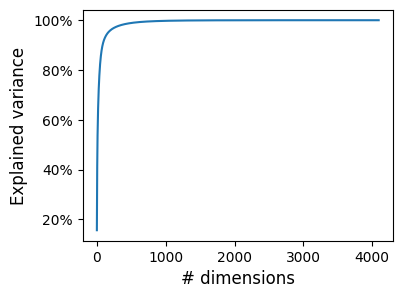